In [470]:
import datetime as dt
import glob
import os
import shutil
import struct
import time
from typing import Dict, List

import matplotlib.pyplot as plt; plt.ion()
import numpy as np
from pathlib import Path


from radio_collar_tracker_dsp2 import PingFinder

In [471]:
RUN_TIME = 8
SDR_TYPE = 3
RANGE = "285"
RX_LOCATION = "11S 477849 3638135 +/- 3"
TX_LOCATION = "11S 478124 3638157 +/- 9"
CHART_OUTPUT_DIR = Path("/mnt/data/2022.07.25.RCT_SDRCompare/")

In [472]:
if SDR_TYPE == 1:
    target_freq = 173965000
    bit_depth = 16
    sdr_name = "USRP"
elif SDR_TYPE == 2:
    target_freq = 173965000
    bit_depth = 12
    sdr_name = "AirSpy"
elif SDR_TYPE == 3:
    target_freq = 173963000
    bit_depth = 8
    sdr_name = "HackRF"

In [473]:
callback_called = 0

pings: List[float] = []
def phony_callback(now: dt.datetime, amplitude:float, frequency: int):
    global pings
    assert(isinstance(now, dt.datetime))
    assert(isinstance(amplitude, float))
    assert(isinstance(frequency, int))
    global callback_called
    callback_called += 1
    pings.append(amplitude)

In [474]:
ping_finder = PingFinder()
ping_finder.gain = 56.0
ping_finder.sampling_rate = 2500000
ping_finder.center_frequency = 173500000
ping_finder.run_num = 1
ping_finder.enable_test_data = False
ping_finder.output_dir = '.'
ping_finder.ping_width_ms = 25
ping_finder.ping_min_snr = 25
ping_finder.ping_max_len_mult = 1.5
ping_finder.ping_min_len_mult = 0.5
ping_finder.target_frequencies = [target_freq]

ping_finder.sdr_type = SDR_TYPE

if ping_finder.sdr_type == 1:
    ping_finder.gain = 56.0
elif ping_finder.sdr_type == 2:
    ping_finder.gain = 14.0
elif ping_finder.sdr_type == 3:
    ping_finder.gain = 40.0

ping_finder.register_callback(phony_callback)
raw_files = glob.glob(os.path.join(ping_finder.output_dir, f"RAW_DATA_{ping_finder.run_num:06d}_*"))
for f in raw_files:
    os.remove(f)

ping_finder.start()

time.sleep(RUN_TIME)

ping_finder.stop()

print(f"Mean amplitude: {np.mean(pings)}")
print(f"std.dev: {np.std(pings)}")
print(f'num ping: {len(pings)}')

Constructing DSP with width of 25 ms
DSP int factor: 7
Setting DSP Start to 1658807461208 ms
87 len id_len
8 len data
17 len pk_hist
174 len peaks
DSP is alive
Opening initial ./RAW_DATA_000001_000001
Ping 0 at 1658807461s , amplitude 8379.805, threshold: 7316.032, width: 5.734, freq: 173963000, bin: 0 was rejected for being too short!
Ping 0 at 1658807461s , amplitude 7697.048, threshold: 7316.321, width: 5.734, freq: 173963000, bin: 0 was rejected for being too short!
Ping 1 at 1658807461265ms , amplitude 9421.048, threshold: 7318.357, width: 22.938, freq: 173963000, idx: 0, bin: 379
Ping 1 at 1658807461s , amplitude 12781.174, threshold: 7320.459, width: 5.734, freq: 173963000, bin: 0 was rejected for being too short!
Ping 2 at 1658807461305ms , amplitude 9628.698, threshold: 7324.397, width: 11.469, freq: 173963000, idx: 0, bin: 379
Ping 2 at 1658807461s , amplitude 14179.135, threshold: 7329.044, width: 5.734, freq: 173963000, bin: 0 was rejected for being too short!
Ping 2 at 165

In [475]:
FFT_LEN = 2048
f_s = 2500000
f_c = 173500000

integral_len = int(np.floor(0.06 * f_s / FFT_LEN))
freqs = np.fft.fftshift(np.fft.fftfreq(FFT_LEN, 1.0/f_s))
closest_freq = min(freqs, key=lambda x:abs(x - (target_freq - f_c)))
fft_bin = min(range(len(freqs)), key=lambda x: abs(freqs[x] - (target_freq - f_c)))

In [476]:
data_dir = "/home/ntlhui/workspace/radio_collar_tracker_dsp2"
raw_files = sorted(glob.glob(os.path.join(data_dir, 'RAW_DATA_*')))

samples = []

shutil.copy(raw_files[0], CHART_OUTPUT_DIR.joinpath(f"{sdr_name}_{RANGE}m.bin").as_posix())

'/mnt/data/2022.07.25.RCT_SDRCompare/HackRF_285m.bin'

In [477]:
raw_file = raw_files[0]
with open(raw_file, 'rb') as data_file:
    data = data_file.read()
scale_factor = 2 ** bit_depth
for i in range(int(len(data) / 4)):
    tsample = struct.unpack('hh', data[i * 4:(i+1) * 4])
    sample = (tsample[0] + tsample[1] * 1j) / scale_factor
    samples.append(sample)
seq_samples = np.array(samples)
arr_samples = np.reshape(seq_samples[0:FFT_LEN*int(len(samples) / FFT_LEN)], (FFT_LEN, int(len(samples) / FFT_LEN)), order='F')
f_samp = np.fft.fft(arr_samples, axis=0) / FFT_LEN
waterfall = np.power(np.abs(np.fft.fftshift(f_samp, axes=0)), 2)

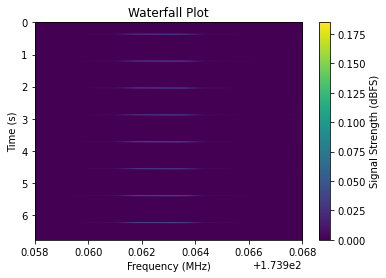

In [478]:
fig, ax = plt.subplots(1)
waterfall_extents = ((f_c - f_s / 2) / 1e6, (f_c + f_s / 2) / 1e6, len(seq_samples) / f_s, 0)
waterfall_plt = plt.imshow(waterfall.transpose(), aspect='auto', extent=waterfall_extents)
waterfall_cbr = plt.colorbar()
plt.ylabel('Time (s)')
plt.xlabel('Frequency (MHz)')
waterfall_cbr.set_label('Signal Strength (dBFS)')
plt.xlim(target_freq/1e6 - 0.005, target_freq/1e6 + 0.005)
plt.title('Waterfall Plot')
plt.savefig(CHART_OUTPUT_DIR.joinpath(f"{sdr_name}_{RANGE}m_waterfall.png").as_posix())

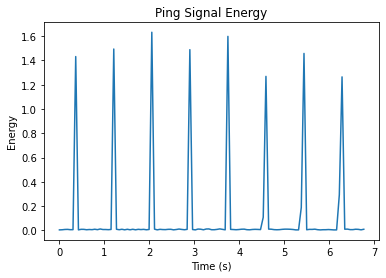

In [479]:
freq_isolate = waterfall[fft_bin,:]
freq_energy = np.zeros(int(len(freq_isolate) / integral_len))

for i in range(len(freq_energy)):
    freq_energy[i] = np.sum(freq_isolate[i * integral_len:(i + 1) * integral_len - 1])
t = np.arange(len(freq_energy)) / (len(freq_energy) - 1) * waterfall_extents[2]
fig1, ax = plt.subplots(1)
plt.plot(t, freq_energy)
plt.ylabel('Energy')
plt.xlabel('Time (s)')
plt.title('Ping Signal Energy')
plt.savefig(CHART_OUTPUT_DIR.joinpath(f"{sdr_name}_{RANGE}m_energy.png").as_posix())


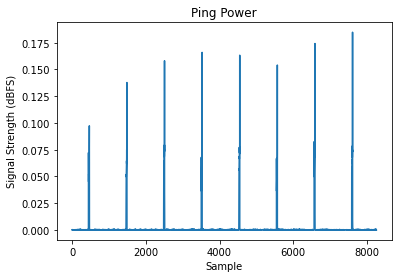

In [480]:
plt.plot(waterfall[fft_bin,:])
plt.ylabel('Signal Strength (dBFS)')
plt.xlabel('Sample')
plt.title("Ping Power")
plt.savefig(CHART_OUTPUT_DIR.joinpath(f"{sdr_name}_{RANGE}m_power.png").as_posix())


In [481]:
with open(CHART_OUTPUT_DIR.joinpath(f"{sdr_name}_{RANGE}m_notes.txt").as_posix(), 'w') as note_file:
    note_file.write(f"TX Location: {TX_LOCATION}\n")
    note_file.write(f"RX Location: {RX_LOCATION}\n")
    note_file.write(f"bit depth: {bit_depth}\n")
    note_file.write(f'target freq: {target_freq}\n')